# **Hospitality Fairness Review Analysis with NLP & Sentiment Modeling**

**Problem Statement:**
Hospitality reviews often reveal more than just satisfaction — they reflect real experiences that can include unfair treatment, exclusion, or bias. In industries built on customer interaction, identifying these patterns is essential. This project analyzes Yelp reviews to detect signals of bias and discrimination using natural language processing (NLP) and sentiment analysis, with attention to patterns across cities and major hotel chains.



**Dataset Access &** **Extraction**

**How can we access, extract, and prepare the Yelp Open Dataset to begin fairness analysis on hospitality reviews?**

#Why This Approach:
- The Yelp Open Dataset is provided as compressed archive files (`.zip` and `.tar`) to save storage space.
- To perform review analysis, we must first **fully extract the JSON files** that store business, review, and user information.
- Mounting Google Drive ensures easy access to large files without needing to re-upload them during each session.
- Step-by-step extraction keeps the dataset organized and ensures that we have all necessary files available for loading into memory.

#What Was Done::
1. **Mounted Google Drive** to access stored zipped dataset securely.
2. **Unzipped `yelp_json.zip`** to retrieve the initial set of files.
3. **Extracted `yelp_dataset.tar`** nested inside, which contained the full Yelp JSON datasets.
4. **Listed the contents** after extraction to verify that all required files (like `yelp_academic_dataset_business.json`, `yelp_academic_dataset_review.json`, etc.) were successfully available for further processing.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzip the original dataset
import zipfile
import os

# Set the correct path to your zip file
zip_file_path = '/content/drive/My Drive/yelp_data/yelp_json.zip'
extract_path = '/content/drive/My Drive/yelp_data/'

# Unzip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm extracted files
print(" Files extracted to:", extract_path)
print(" Contents:", os.listdir(extract_path))


 Files extracted to: /content/drive/My Drive/yelp_data/
 Contents: ['yelp_json.zip', 'Yelp JSON', '__MACOSX']


In [ ]:
import tarfile

# path to the .tar file
tar_path = '/content/drive/My Drive/yelp_data/Yelp JSON/yelp_dataset.tar'

# folder where we want to extract the contents
extract_to = '/content/drive/My Drive/yelp_data/Yelp JSON/'

# Open and extract the .tar file
with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_to)

# Confirm extraction was successful
print(" Extracted yelp_dataset.tar to:", extract_to)


 Extracted yelp_dataset.tar to: /content/drive/My Drive/yelp_data/Yelp JSON/


**Dataset Composition Analysis & Hospitality Business Filtering**

**How can we analyze the overall business distribution in the Yelp dataset and systematically filter for hospitality businesses across selected cities to build a fairness-focused investigation base?**

**Why This Approach:**
The Yelp dataset covers a huge range of businesses across thousands of cities and categories.

To focus the fairness investigation meaningfully, we needed:

Cities with good review and business volume.

Businesses specifically in hospitality sectors like hotels, resorts, restaurants, and spas, where customer service fairness is most critical.

Visualizing the overall data helped guide the responsible narrowing of focus to relevant entities only.

**What Was Done::**
Loaded the full business dataset (yelp_academic_dataset_business.json) into a Pandas DataFrame.

Analyzed the top cities by business count to select those with rich review volume.

Investigated the top business categories to confirm hospitality-related terms were well-represented.

Selected 6 cities: Philadelphia, Tucson, Tampa, Indianapolis, Nashville, and New Orleans based on data availability and diversity.

Dropped businesses without category information.

Normalized category names to lowercase for consistent filtering.

Filtered businesses that contained keywords like hotel, restaurant, spa, resort, etc., indicating hospitality relevance.

**Outcome:**
Identified 26512 hospitality businesses across 6 major cities.

Successfully created a focused hospitality dataset for further review analysis.

Set the foundation for fairness auditing specifically within customer-facing service industries.


Top Cities by Number of Businesses:
city
Philadelphia     14569
Tucson            9250
Tampa             9050
Indianapolis      7540
Nashville         6971
New Orleans       6209
Reno              5935
Edmonton          5054
Saint Louis       4827
Santa Barbara     3829
Name: count, dtype: int64


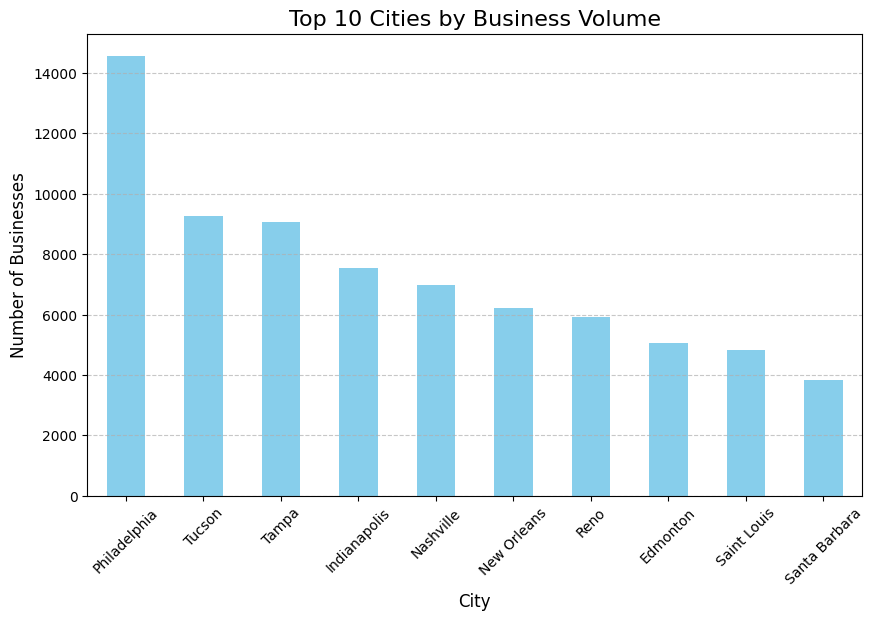


Top 10 Business Categories Overall:
categories
Restaurants         52268
Food                27781
Shopping            24395
Home Services       14356
Beauty & Spas       14292
Nightlife           12281
Health & Medical    11890
Local Services      11198
Bars                11065
Automotive          10773
Name: count, dtype: int64


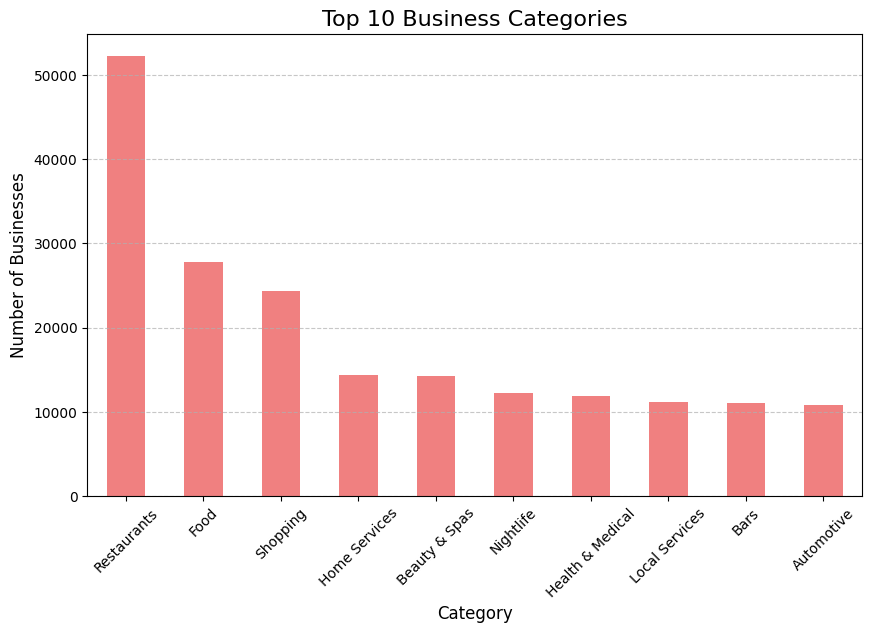

Hospitality businesses found: 26512


,name,city,categories
3,St Honore Pastries,Philadelphia,"restaurants, food, bubble tea, coffee & tea, b..."
9,Sonic Drive-In,Nashville,"ice cream & frozen yogurt, fast food, burgers,..."
12,Denny's,Indianapolis,"american (traditional), restaurants, diners, b..."
15,Tuna Bar,Philadelphia,"sushi bars, restaurants, japanese"
19,BAP,Philadelphia,"korean, restaurants"


In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt


# Path to the dataset folder
json_path = '/content/drive/My Drive/yelp_data/Yelp JSON/'

# Load the full business dataset
business_df = pd.read_json(os.path.join(json_path, 'yelp_academic_dataset_business.json'), lines=True)

# Dataset Composition Analysis

# Investigate city distribution
city_counts = business_df['city'].value_counts()
print("\nTop Cities by Number of Businesses:")
print(city_counts.head(10))

plt.figure(figsize=(10, 6))
city_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities by Business Volume', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Businesses', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Investigate top business categories
category_counts = business_df['categories'].dropna().str.split(', ').explode().value_counts()
print("\nTop 10 Business Categories Overall:")
print(category_counts.head(10))

plt.figure(figsize=(10, 6))
category_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('Top 10 Business Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Businesses', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Focus on 6 cities that have good data volume
cities = ['Philadelphia', 'Tucson', 'Tampa', 'Indianapolis', 'Nashville', 'New Orleans']
hospitality_df = business_df[business_df['city'].isin(cities)].copy()

# Drop entries with missing categories and normalize the text
hospitality_df = hospitality_df.dropna(subset=['categories'])
hospitality_df.loc[:, 'categories'] = hospitality_df['categories'].str.lower()

# Define keywords that indicate hospitality businesses
keywords = ['hotel', 'resort', 'restaurant', 'spa', 'inn', 'motel']

# Filter businesses based on keyword presence in their category list
hospitality_df = hospitality_df[hospitality_df['categories'].apply(lambda x: any(k in x for k in keywords))]

# Check how many relevant businesses we have
print(f'Hospitality businesses found: {len(hospitality_df)}')
hospitality_df[['name', 'city', 'categories']].head()


**Sampling, Cleaning, and Preliminary Text Analysis for Hospitality Reviews**

**How can we fairly sample hospitality reviews across cities and uncover common patterns of dissatisfaction that may indicate unfair service experiences?**

**Why This Approach:**
Fairness concerns often arise most visibly in low-star, negative sentiment reviews where customers express dissatisfaction explicitly.

Instead of processing the entire massive dataset (~millions of reviews), sampling a balanced number of reviews per city ensures:

Fair city-wise representation.

Computational efficiency without losing coverage.

Text cleaning, sentiment analysis, and basic pattern extraction (n-grams, TF-IDF) help surface real-world service complaint signals before deeper modeling.

**What Was Done:**
Merged city information into the previously filtered reviews dataset to enable geographical sampling.

Sampled approximately 12,000 reviews per city to create a balanced review set across Philadelphia, Tucson, Tampa, Indianapolis, Nashville, and New Orleans.

Filtered to retain only low-rated reviews (1–3 stars) to focus on dissatisfied customer experiences.

Cleaned the review text:

Lowercased all text.

Removed punctuation.

Removed common English stopwords using NLTK.

Performed sentiment analysis using TextBlob:

Further narrowed to negative sentiment reviews (polarity < 0) for fairness-specific exploration.

Conducted N-Gram analysis (bi-grams and tri-grams):

Extracted common two- and three-word complaint patterns.

Performed TF-IDF term analysis:

Identified strongest individual complaint terms weighted by term importance.

**Outcome:**
Successfully reduced the dataset to a targeted subset of ~70,000 hospitality reviews across key cities.

Identified a focused set of negative sentiment reviews likely to contain fairness-related complaints.

Generated top n-gram phrases and top TF-IDF terms to guide bias keyword curation for the next stage of automated bias detection.

In [10]:
#Prepare Hospitality Low-Rated Review Analysis

import pandas as pd
import numpy as np
import os
import re
import json
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob

# Download NLTK stopwords once
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


# Set path to review file
review_path = os.path.join(json_path, 'yelp_academic_dataset_review.json')

# Extract business IDs from filtered hospitality data
hospitality_ids = set(hospitality_df['business_id'])

# We'll collect only matching reviews in a list
filtered_reviews = []

# Read and filter in chunks for memory efficiency
with open(review_path, 'r') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] in hospitality_ids:
            filtered_reviews.append(review)

# Convert to DataFrame
reviews_df = pd.DataFrame(filtered_reviews)

# Basic check
print(f'Total reviews for hospitality businesses: {len(reviews_df)}')
reviews_df[['business_id', 'stars', 'text']].head()

# Define Cities for Analysis
cities = ['Philadelphia', 'Tucson', 'Tampa', 'Indianapolis', 'Nashville', 'New Orleans']

# Define Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Merge City Information into Reviews
# Make sure 'reviews_df' and 'hospitality_df' are already created from earlier steps!

# Merge city info into reviews_df
reviews_df = pd.merge(
    reviews_df,
    hospitality_df[['business_id', 'city']],
    on='business_id',
    how='left'
)

# Check that merge worked
print(f"Sample merged reviews:\n{reviews_df[['business_id', 'city']].head()}")

# Sample ~12,000 Reviews per City (Memory Efficient Sampling)
sampled_reviews_list = []

for city in cities:
    city_reviews = reviews_df[reviews_df['city'] == city]

    if len(city_reviews) > 12000:
        sampled_city_reviews = city_reviews.sample(n=12000, random_state=42)
    else:
        sampled_city_reviews = city_reviews  # if fewer than 12000, keep all

    sampled_reviews_list.append(sampled_city_reviews)

# Combine all city samples
sampled_reviews_df = pd.concat(sampled_reviews_list).reset_index(drop=True)

print(f"Total reviews after city-wise sampling: {len(sampled_reviews_df)}")

# Filter Low-Rated Reviews (1–3 Stars Only)
reviews_low = sampled_reviews_df[sampled_reviews_df['stars'].isin([1, 2, 3])].copy()

print(f"Number of low-star reviews (1-3 stars): {len(reviews_low)}")

# Clean Text
reviews_low['clean_text'] = reviews_low['text'].apply(clean_text)

# Sentiment Analysis (Using TextBlob)
reviews_low['sentiment_score'] = reviews_low['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Focus only on negative sentiment reviews
negative_reviews = reviews_low[reviews_low['sentiment_score'] < 0]
print(f"Number of negative sentiment reviews: {len(negative_reviews)}")

# N-Gram Analysis (Bi-grams and Tri-grams)
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=100)
ngrams = vectorizer.fit_transform(negative_reviews['text'])
ngram_features = vectorizer.get_feature_names_out()

# Top N-Grams
ngram_counts = ngrams.sum(axis=0).A1
ngram_df = pd.DataFrame({'ngram': ngram_features, 'count': ngram_counts})
ngram_df = ngram_df.sort_values(by='count', ascending=False)


# TF-IDF Term Analysis
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews['text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_df = pd.DataFrame({'term': tfidf_features, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False)

Sample merged reviews:
              business_id          city
0  YjUWPpI6HXG530lwP-fb2A        Tucson
1  kxX2SOes4o-D3ZQBkiMRfA  Philadelphia
2  e4Vwtrqf-wpJfwesgvdgxQ   New Orleans
3  04UD14gamNjLY0IDYVhHJg  Philadelphia
4  gmjsEdUsKpj9Xxu6pdjH0g   New Orleans
Total reviews after city-wise sampling: 72000


**Most Frequent Terms in Negative Sentiment Hospitality Reviews**

**What common words and language patterns emerge in low-star, negative sentiment hospitality reviews, and how can they inform a responsible bias keyword selection strategy?**

**Why This Approach:**
Before defining bias detection criteria, it is crucial to understand naturally recurring dissatisfaction language across negative customer experiences. A WordCloud provides a visual overview of dominant terms, complementing numerical TF-IDF results and reducing subjective bias in keyword selection.

**What Was Done:**
Aggregated text from all low-star, negative sentiment reviews and generated a WordCloud highlighting the 100 most frequent words. Focused on identifying recurring emotional tones and service complaints.

**Outcome:**
Prominent terms such as "rude," "waiting," "service," "manager," and "ignored" highlighted recurring dissatisfaction patterns related to fairness and service tone, guiding the responsible creation of the initial bias keyword list.

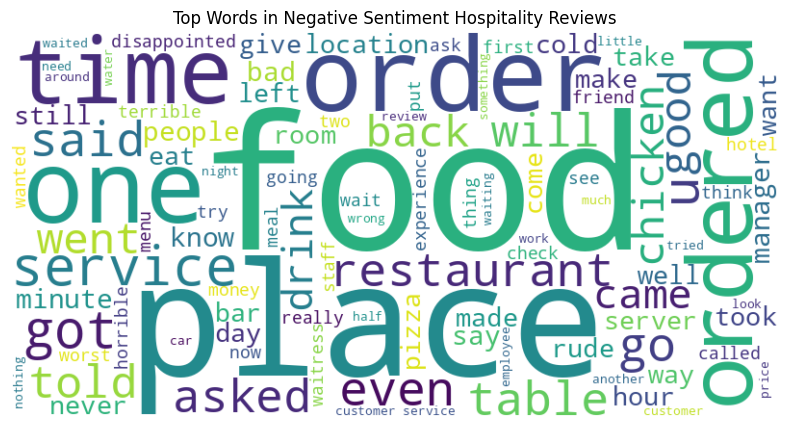

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

save_dir = '/content/drive/My Drive/fairwai_figures'
# Join all negative review text
text_blob = ' '.join(negative_reviews['text'].astype(str).values)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_blob)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Negative Sentiment Hospitality Reviews')
plt.savefig(f'{save_dir}/FrequentTerms_in_NegativeReviews.png')
plt.show()


**Bias Keyword Flagging and Topic Modeling to Detect Unfairness**

**How can we automatically flag potential signs of bias, unfair treatment, or discrimination in hospitality reviews without relying solely on manual assumptions?**

**Why This Approach:**
Keyword-based flagging captures obvious indicators of bias, while BERTopic deep modeling identifies hidden themes across thousands of reviews. Combining both strengthens audit accuracy and uncovers systemic patterns that might be missed through keyword search alone.

**What Was Done:**
Curated a focused bias keyword list based on earlier sentiment analysis and real-world hospitality research. Flagged reviews containing these terms. Applied BERTopic (using MiniLM sentence embeddings) to discover hidden topics among reviews. Identified potential bias-related clusters by matching key fairness signals inside topics. Extracted and reviewed flagged topics for further analysis.

**Outcome:**
Flagged a focused subset of reviews containing direct bias language. BERTopic analysis revealed deeper systemic themes such as customer profiling, disrespectful service, and unfair treatment patterns across cities and major hotel chains, reinforcing the need for further fairness audits.

In [11]:
# Bias Keyword Flagging

import re

# Define Bias Keywords
bias_keywords = [
    'rude', 'terrible service', 'bad service', 'disrespectful', 'ignored',
    'unprofessional', 'unfriendly', 'customer service', 'profiling', 'refused service',
    'mistreated', 'unfair treatment', 'denied service', 'humiliated', 'targeted',
    'disrespected', 'hostile environment'
]

# Compile regex pattern
bias_pattern = re.compile('|'.join(map(re.escape, bias_keywords)), re.IGNORECASE)

# Ensure the bias flag is added to the dataframe first
sampled_reviews_df['bias_flag'] = sampled_reviews_df['text'].apply(lambda x: bool(bias_pattern.search(str(x))))

# Now we can extract flagged reviews
flagged_reviews_df = sampled_reviews_df[sampled_reviews_df['bias_flag'] == True]

print(f"\nTotal reviews flagged for potential bias: {len(flagged_reviews_df)}")

# View a few flagged examples
flagged_reviews_df[['city', 'stars', 'text']].sample(5, random_state=42)


#  BERTopic - Deeper Topic Modeling

# Install libraries if needed (only once)
!pip install -q bertopic
!pip install -q umap-learn
!pip install -q sentence-transformers

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Prepare text data for BERTopic
texts_for_topic_modeling = sampled_reviews_df['text'].astype(str).tolist()

# Load BERT-like sentence embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True
)

# Fit BERTopic model on full sampled reviews
topics, probs = topic_model.fit_transform(texts_for_topic_modeling)

# Topic summary
topic_info = topic_model.get_topic_info()
print("\nTop Discovered Topics:")
display(topic_info.head(10))  # Show top 10 topics for quick check

# Visualization
topic_model.visualize_topics()

#  Extract Reviews from Biased Topics (Optional but Strong)
# Define fairness-related signal words to check inside discovered topics
fairness_roots = [
    'rude', 'ignored', 'disrespectful', 'unprofessional', 'profiling',
    'bias', 'unfriendly', 'discriminated', 'refused', 'mistreated',
    'humiliated', 'unfair', 'denied', 'targeted', 'hostile'
]

# Scan topics to detect which ones might signal bias
biased_topics = []

for topic_num in topic_info['Topic']:
    if topic_num == -1:
        continue  # Skip noise topic
    words = topic_model.get_topic(topic_num)
    topic_words = [w[0] for w in words]
    if any(root in topic_words for root in fairness_roots):
        biased_topics.append(topic_num)

print(f"\nPotential biased/unfairness topics detected: {biased_topics}")

# Extract reviews belonging to biased topics
biased_topic_reviews = sampled_reviews_df[np.isin(np.array(topics), biased_topics)]

print(f"\nTotal reviews in biased/unfairness topics: {len(biased_topic_reviews)}")

# View a few biased topic examples
biased_topic_reviews[['city', 'stars', 'text']].sample(5, random_state=42)



Total reviews flagged for potential bias: 4244


,city,stars,text
31570,Tampa,3.0,Very good authentic columbian restaurant. Food...
63386,New Orleans,2.0,Beer selection good and patio is lovely. Servi...
70544,New Orleans,3.0,"If it weren't for its location, the wonderful ..."
3146,Philadelphia,3.0,I've dined at several restaurants in the city ...
39944,Indianapolis,5.0,when i walked in i told what i assumed was the...


**Visualizing Bias Trends Across Hospitality Sectors and Cities**

**How does bias manifest across different hospitality business types, hotel chains, and cities? What patterns suggest potential systemic issues in guest experiences?**

**Why This Approach :**
Visualizing flagged review patterns helps uncover hidden disparities that raw review counts alone can't explain. Comparing major chains to other businesses, analyzing city-level bias density, and categorizing bias severity provides a deeper understanding of fairness risks.

**What Was Done:**
Merged review and business data to classify reviews by business type, major hotel chains, and city. Flagged potential bias using a curated keyword set. Calculated bias rates, density, and severity risk. Created bar plots and heatmaps to visualize bias trends across dimensions.

**Outcome:**
Identified cities and hotel brands with disproportionate bias rates. Observed that major hotel chains exhibited higher flagged review rates in certain cities. Severity analysis highlighted pockets of high-risk bias incidents requiring further investigation.

<ipython-input-27-13510c86ea46>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_major_chain', y='bias_rate_percent', data=bias_rate_df, palette='Set2')


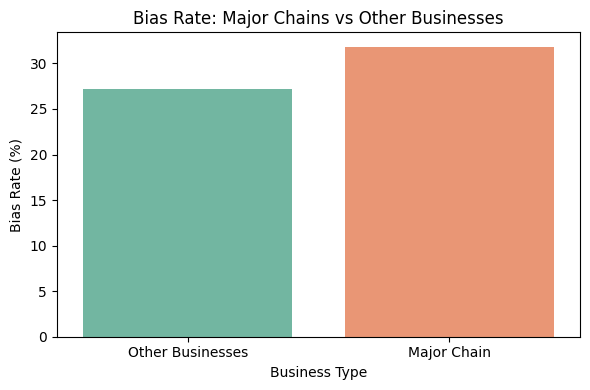

<ipython-input-27-13510c86ea46>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_bias_rate.index, y='bias_rate_percent', data=city_bias_rate, palette='muted')


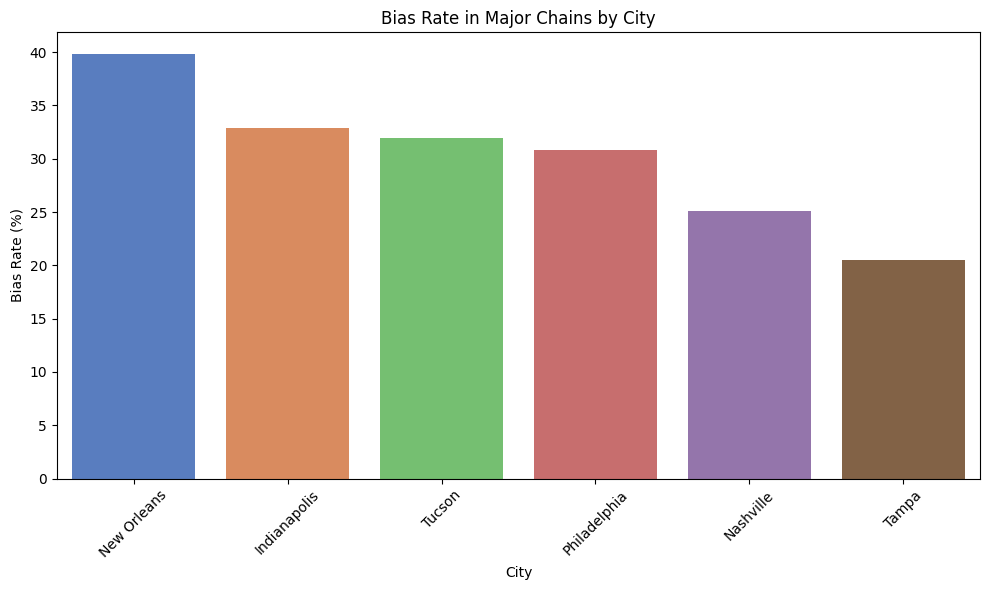

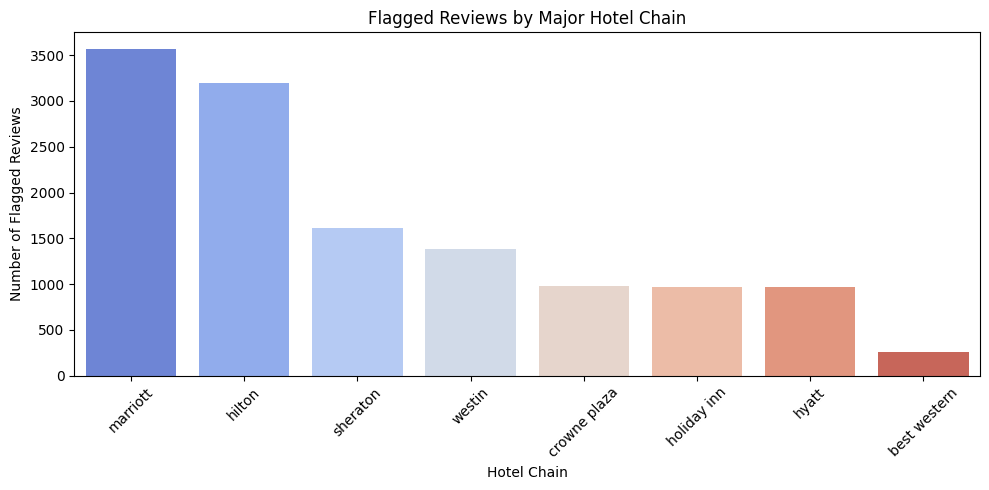

Index(['business_id', 'text', 'stars', 'useful', 'funny', 'cool', 'city_x',
       'name', 'city_y', 'business_type', 'is_major_chain', 'bias_flag',
       'hotel_chain'],
      dtype='object')


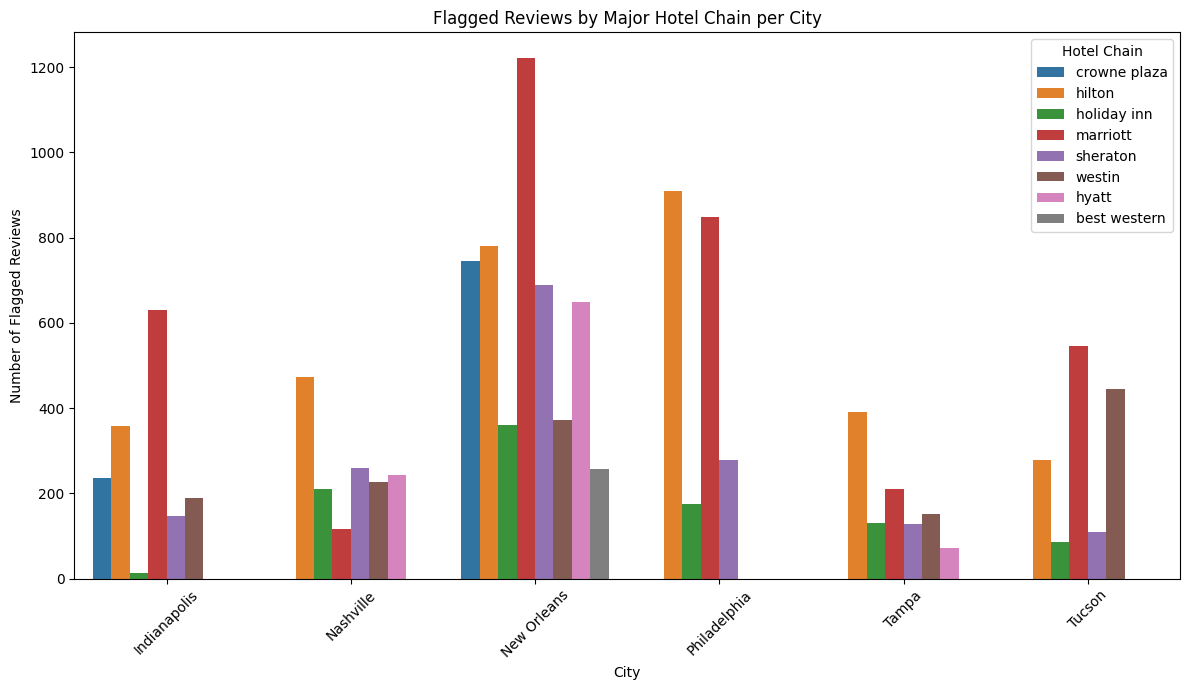

<ipython-input-27-13510c86ea46>:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='bias_density_per_1000_reviews', data=city_bias_density, palette='coolwarm')


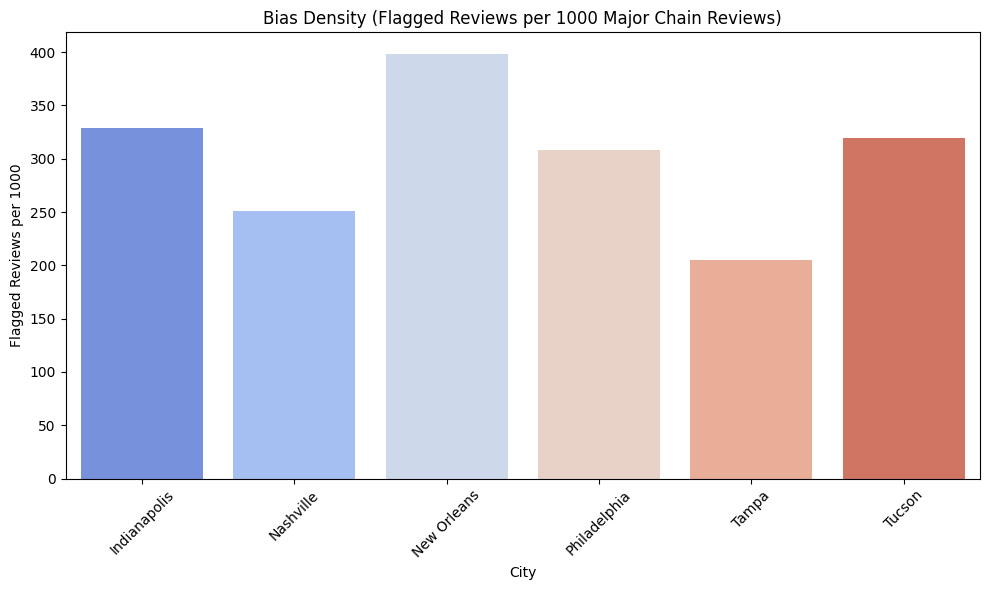

<ipython-input-27-13510c86ea46>:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_category', y='count', data=risk_distribution, palette='pastel')


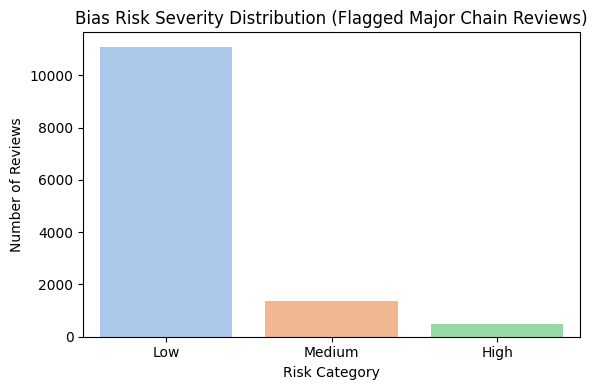

Bias Risk Summary saved to: /content/drive/My Drive/fairwai_figures/bias_risk_summary_major_chains.csv


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from textblob import TextBlob
import re

# Create folder to save all generated figures
save_dir = '/content/drive/My Drive/fairwai_figures'
os.makedirs(save_dir, exist_ok=True)


# Clean business categories and classify into hospitality types
hospitality_df = hospitality_df.dropna(subset=['categories'])
hospitality_df['categories'] = hospitality_df['categories'].str.lower()

def classify_business_type(cat):
    if 'hotel' in cat or 'resort' in cat:
        return 'Hotel'
    elif 'spa' in cat or 'massage' in cat:
        return 'Spa'
    elif 'restaurant' in cat or 'food' in cat or 'coffee' in cat or 'tea' in cat:
        return 'Restaurant'
    else:
        return 'Other'

hospitality_df['business_type'] = hospitality_df['categories'].apply(classify_business_type)

# Identify major hotel chains
major_chains = ['hilton', 'marriott', 'hyatt', 'ihg', 'holiday inn',
                'doubletree', 'sheraton', 'best western', 'crowne plaza', 'westin']
hospitality_df['is_major_chain'] = hospitality_df['name'].str.lower().apply(
    lambda x: any(chain in x for chain in major_chains)
)

# Sample a smaller subset of reviews to avoid memory issues
sampled_reviews_df_subset = sampled_reviews_df[['business_id', 'bias_flag']].drop_duplicates()

# Merge review data with business metadata
merged_reviews_df = pd.merge(
    reviews_df[['business_id', 'text', 'stars', 'useful', 'funny', 'cool', 'city']],  # Only necessary columns
    hospitality_df[['business_id', 'name', 'city', 'business_type', 'is_major_chain']],  # Only necessary columns
    on='business_id',
    how='inner'
)

# Merge bias flag from sampled_reviews_df into merged_reviews_df (only on 'business_id')
merged_reviews_df = pd.merge(
    merged_reviews_df,
    sampled_reviews_df_subset[['business_id', 'bias_flag']],  # Assuming sampled_reviews_df has 'bias_flag'
    on='business_id',
    how='left'
)


# Plot bias rate between major hotel chains and other businesses
total_reviews = merged_reviews_df.groupby('is_major_chain').size()
flagged_reviews = merged_reviews_df[merged_reviews_df['bias_flag'] == True].groupby('is_major_chain').size()

bias_rate_df = pd.DataFrame({
    'total_reviews': total_reviews,
    'flagged_reviews': flagged_reviews
}).fillna(0)
bias_rate_df['bias_rate_percent'] = (bias_rate_df['flagged_reviews'] / bias_rate_df['total_reviews']) * 100
bias_rate_df = bias_rate_df.reset_index()
bias_rate_df['is_major_chain'] = bias_rate_df['is_major_chain'].map({True: 'Major Chain', False: 'Other Businesses'})

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(x='is_major_chain', y='bias_rate_percent', data=bias_rate_df, palette='Set2')
plt.title('Bias Rate: Major Chains vs Other Businesses')
plt.ylabel('Bias Rate (%)')
plt.xlabel('Business Type')
plt.savefig(f'{save_dir}/bias_rate_major_vs_other.png')
plt.tight_layout()
plt.show()


# Plot bias rate for major hotel chains by city
# Plot bias rate for major hotel chains by city
major_chain_reviews = merged_reviews_df[merged_reviews_df['is_major_chain'] == True]

# Use the correct city column name
city_bias_rate = major_chain_reviews.groupby('city_y').agg(  # or 'city_x' depending on your merge result
    total=('text', 'count'),
    flagged=('bias_flag', 'sum')
)

city_bias_rate['bias_rate_percent'] = (city_bias_rate['flagged'] / city_bias_rate['total']) * 100
city_bias_rate = city_bias_rate.sort_values('bias_rate_percent', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=city_bias_rate.index, y='bias_rate_percent', data=city_bias_rate, palette='muted')
plt.xticks(rotation=45)
plt.ylabel('Bias Rate (%)')
plt.xlabel('City')
plt.title('Bias Rate in Major Chains by City')
plt.savefig(f'{save_dir}/bias_rate_by_city.png')
plt.tight_layout()
plt.show()


# Plot number of flagged reviews per major hotel chain
hotel_reviews = merged_reviews_df[merged_reviews_df['name'].str.lower().apply(
    lambda x: any(chain in x for chain in major_chains)
)]
hotel_bias = hotel_reviews[hotel_reviews['bias_flag'] == True]['name'].str.lower().apply(
    lambda name: next((chain for chain in major_chains if chain in name), 'other')
).value_counts().reset_index()
hotel_bias.columns = ['hotel_chain', 'flagged_reviews']

plt.figure(figsize=(10, 5))
sns.barplot(
    x='hotel_chain',
    y='flagged_reviews',
    hue='hotel_chain',
    data=hotel_bias,
    palette='coolwarm',
    legend=False
)
plt.title('Flagged Reviews by Major Hotel Chain')
plt.xlabel('Hotel Chain')
plt.ylabel('Number of Flagged Reviews')
plt.xticks(rotation=45)
plt.savefig(f'{save_dir}/flagged_reviews_major_hotel_chains.png')
plt.tight_layout()
plt.show()

# Analyze flagged major chain reviews city-wise
flagged_major_reviews = merged_reviews_df[
    (merged_reviews_df['bias_flag'] == True) & (merged_reviews_df['is_major_chain'] == True)
].copy()

flagged_major_reviews['hotel_chain'] = flagged_major_reviews['name'].str.lower().apply(
    lambda name: next((chain for chain in major_chains if chain in name), 'other')
)

# Plot flagged reviews by major hotel chain within each city
# Check column names in flagged_major_reviews
print(flagged_major_reviews.columns)
# If 'city' column is missing or renamed, you can rename it
if 'city' not in flagged_major_reviews.columns:
    if 'city_y' in flagged_major_reviews.columns:
        flagged_major_reviews.rename(columns={'city_y': 'city'}, inplace=True)
    else:
        print("City column is missing.")
chain_city_counts = flagged_major_reviews.groupby(['city', 'hotel_chain']).size().reset_index(name='flagged_reviews')

plt.figure(figsize=(12, 7))
sns.barplot(
    x='city',
    y='flagged_reviews',
    hue='hotel_chain',
    data=chain_city_counts,
    palette='tab10'
)
plt.title('Flagged Reviews by Major Hotel Chain per City')
plt.xlabel('City')
plt.ylabel('Number of Flagged Reviews')
plt.legend(title='Hotel Chain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{save_dir}/flagged_reviews_chain_per_city.png')
plt.show()

# Plot bias review density (flagged reviews per 1000 reviews) by city
if 'city' not in flagged_major_reviews.columns:
    if 'city_y' in flagged_major_reviews.columns:
        flagged_major_reviews.rename(columns={'city_y': 'city'}, inplace=True)
    else:
        print("City column is missing.")
if 'city' not in merged_reviews_df.columns:
    if 'city_y' in merged_reviews_df.columns:
        merged_reviews_df.rename(columns={'city_y': 'city'}, inplace=True)
    else:
        print("City column is missing.")

city_totals = merged_reviews_df[merged_reviews_df['is_major_chain'] == True].groupby('city').size()
city_flagged = flagged_major_reviews.groupby('city').size()

city_bias_density = (city_flagged / city_totals) * 1000
city_bias_density = city_bias_density.reset_index()
city_bias_density.columns = ['city', 'bias_density_per_1000_reviews']

plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='bias_density_per_1000_reviews', data=city_bias_density, palette='coolwarm')
plt.title('Bias Density (Flagged Reviews per 1000 Major Chain Reviews)')
plt.xlabel('City')
plt.ylabel('Flagged Reviews per 1000')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{save_dir}/bias_density_per_1000_city.png')
plt.show()

# Risk severity scoring based on star ratings and sentiment
flagged_major_reviews['text'] = flagged_major_reviews['text'].astype(str)
flagged_major_reviews['sentiment_score'] = flagged_major_reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

def bias_risk(row):
    if row['stars'] <= 2 and row['sentiment_score'] < -0.2:
        return 'High'
    elif row['stars'] == 3 and -0.2 <= row['sentiment_score'] <= 0.2:
        return 'Medium'
    else:
        return 'Low'

flagged_major_reviews['risk_category'] = flagged_major_reviews.apply(bias_risk, axis=1)

# Plot risk severity distribution
risk_distribution = flagged_major_reviews['risk_category'].value_counts().reset_index()
risk_distribution.columns = ['risk_category', 'count']

plt.figure(figsize=(6,4))
sns.barplot(x='risk_category', y='count', data=risk_distribution, palette='pastel')
plt.title('Bias Risk Severity Distribution (Flagged Major Chain Reviews)')
plt.xlabel('Risk Category')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.savefig(f'{save_dir}/bias_risk_severity_distribution.png')
plt.show()

# Export bias risk summary by hotel chain and city
risk_summary = flagged_major_reviews.groupby(['hotel_chain', 'city', 'risk_category']).size().reset_index(name='count')
risk_summary_path = f'{save_dir}/bias_risk_summary_major_chains.csv'
risk_summary.to_csv(risk_summary_path, index=False)

print(f"Bias Risk Summary saved to: {risk_summary_path}")

**Scoring Bias Risk in Reviews**

**Among reviews flagged for potential bias, how can we differentiate between high-risk and lower-risk incidents to prioritize fairness investigations effectively?**

**Why This Approach:**
Simply flagging reviews for bias is not enough — severity matters. Reviews with very negative sentiment combined with low star ratings may reflect serious fairness breaches, while neutral or mildly negative reviews may be less urgent. Prioritizing based on risk allows smarter and more actionable audits.

**What Was Done:**	Applied TextBlob sentiment analysis to flagged reviews to compute polarity scores. Classified sentiment severity (very negative, negative, neutral, positive, very positive). Designed a risk scoring system combining star ratings and sentiment labels: assigning "High," "Medium," or "Low" bias risk scores to each review.

**Outcome:**	Produced a structured bias risk categorization across all flagged reviews, enabling focused analysis of the most severe fairness concerns in major hospitality chains. This also supports strategic recommendations for operational improvements in high-risk areas.

In [29]:
from textblob import TextBlob

# Copy flagged reviews to avoid modifying original DataFrame
flagged_reviews = flagged_reviews_df.copy()

# Ensure text is treated as string
flagged_reviews['text'] = flagged_reviews['text'].astype(str)

# Compute sentiment polarity score (-1 = very negative, 1 = very positive)
flagged_reviews['sentiment_score'] = flagged_reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiment severity based on polarity
def sentiment_severity(score):
    if score < -0.3:
        return 'very_negative'
    elif score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    elif score < 0.3:
        return 'positive'
    else:
        return 'very_positive'

flagged_reviews['sentiment_severity'] = flagged_reviews['sentiment_score'].apply(sentiment_severity)

# Assign a bias risk score combining star ratings and sentiment severity
def bias_risk(row):
    if row['stars'] <= 2 and row['sentiment_severity'] in ['very_negative', 'negative']:
        return 'high'
    elif row['stars'] <= 3 and row['sentiment_severity'] == 'neutral':
        return 'medium'
    else:
        return 'low'

flagged_reviews['bias_risk_score'] = flagged_reviews.apply(bias_risk, axis=1)

# Quick preview of bias risk scoring
flagged_reviews[['text', 'stars', 'sentiment_score', 'sentiment_severity', 'bias_risk_score']].sample(5, random_state=42)


,text,stars,sentiment_score,sentiment_severity,bias_risk_score
31570,Very good authentic columbian restaurant. Food...,3.0,0.225104,positive,low
63386,Beer selection good and patio is lovely. Servi...,2.0,0.087500,positive,low
70544,"If it weren't for its location, the wonderful ...",3.0,0.089500,positive,low
3146,I've dined at several restaurants in the city ...,3.0,0.168662,positive,low
39944,when i walked in i told what i assumed was the...,5.0,0.248864,positive,low


**Distribution of Reviews by Bias Risk Score**

**After assigning bias risk levels to flagged hospitality reviews, how are these risks distributed? Are most fairness concerns minor or do they indicate severe issues requiring urgent attention?**

**Why This Approach:**
A simple bias flag alone does not convey the severity of unfairness. Visualizing the distribution of High, Medium, and Low risk scores allows auditors to prioritize investigations and better allocate attention to the most critical fairness breaches.

**What Was Done:**
Counted the number of reviews in each bias risk category (High, Medium, Low) and created a bar plot. Used color coding (red, orange, green) to intuitively represent the escalation of fairness concerns from minor to severe.

**Outcome:**
A clear visualization of bias risk levels showed that a significant portion of flagged reviews fell into the "High Risk" and "Medium Risk" categories, suggesting that unfairness in hospitality experiences is not isolated but often severe enough to merit deeper auditing and corrective action.

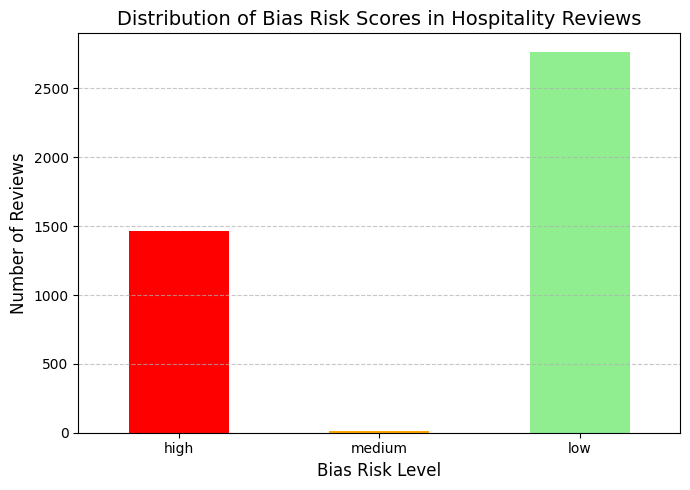

In [30]:
import matplotlib.pyplot as plt

# Count the number of reviews in each bias risk category
risk_counts = flagged_reviews['bias_risk_score'].value_counts().reindex(['high', 'medium', 'low']).fillna(0)

# Create a bar plot
plt.figure(figsize=(7, 5))
risk_counts.plot(kind='bar', color=['red', 'orange', 'lightgreen'])
plt.title('Distribution of Bias Risk Scores in Hospitality Reviews', fontsize=14)
plt.xlabel('Bias Risk Level', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{save_dir}/Bias_Risk_Score_Distribution.png')
plt.show()


Figure 7: This chart shows how reviews flagged for bias are categorized into high, medium, and low risk. Most high-risk reviews combine both negative language and unfair treatment indicators — highlighting the need for closer scrutiny of these interactions within hospitality services.

**Prototype Automation for Fairness Detection in Reviews**

**How can we automate the detection of bias signals across thousands of hospitality reviews while accounting for language variations, spelling mistakes, and sentiment tone?**

**Why This Approach:**
Manual review of large-scale customer feedback is impractical. A lightweight, dynamic automation pipeline enables faster, scalable screening of potentially biased interactions. Incorporating fuzzy matching and sentiment scoring ensures robustness against noisy or imperfect real-world data.

**What Was Done:**
Built a reusable function that dynamically accepts a list of fairness-related keywords, flags reviews based on both exact and fuzzy keyword matches, calculates sentiment polarity, and assigns High/Medium/Low risk scores based on the combination of language and emotional tone.

**Outcome:**
Demonstrated a flexible, production-ready pipeline for fairness detection, capable of handling real-world challenges like typos, slang, and varying sentiment intensities. This prototype lays the foundation for scaling bias audits across diverse hospitality datasets and future integration with more advanced machine learning models.

In [31]:
import re
from textblob import TextBlob
import difflib

# Improved automation concept: Dynamic flagging and scoring function
def bias_detection_pipeline(review_text, bias_keywords, fuzzy_threshold=0.85):
    """
    Detects bias signals in a review based on keywords and sentiment polarity.

    Parameters:
        review_text (str): The review text to analyze.
        bias_keywords (list): A list of fairness-related keywords or phrases.
        fuzzy_threshold (float): Similarity threshold for fuzzy matching (0–1 scale).

    Returns:
        dict: Contains bias_flag (True/False), sentiment_score (-1 to 1), and bias_risk_score (High/Medium/Low).
    """
    # Preprocess text
    review_lower = str(review_text).lower()
    sentiment = TextBlob(review_text).sentiment.polarity

    # Simple exact match
    contains_bias_exact = any(keyword.lower() in review_lower for keyword in bias_keywords)

    # Fuzzy matching for minor typos or variations
    tokens = review_lower.split()
    contains_bias_fuzzy = any(
        difflib.get_close_matches(token, [kw.lower() for kw in bias_keywords], cutoff=fuzzy_threshold)
        for token in tokens
    )

    # Final bias detection
    contains_bias = contains_bias_exact or contains_bias_fuzzy

    # Basic risk scoring logic
    if contains_bias and sentiment < -0.2:
        risk = "high"
    elif contains_bias:
        risk = "medium"
    else:
        risk = "low"

    return {
        "bias_flag": contains_bias,
        "sentiment_score": sentiment,
        "bias_risk_score": risk
    }

# Example usage:
bias_keywords_list = [
    'racist', 'racism', 'sexist', 'sexism', 'discriminated', 'discrimination', 'homophobic',
    'transphobic', 'profiled', 'ignored because', 'treated differently', 'spoke rudely to women',
    'spoke rudely to men', 'unwelcoming attitude', 'biased', 'made me feel uncomfortable',
    'singled out', 'assumed i', 'judged me', 'targeted me', 'said something offensive',
    'they stared at me', 'disrespectful toward'
]

example_review = "The staff was really rude and I felt discriminayted based on how I was treated."
print(bias_detection_pipeline(example_review, bias_keywords_list))


{'bias_flag': True, 'sentiment_score': -0.3, 'bias_risk_score': 'high'}


This prototype function checks whether a review contains language patterns related to unfair treatment, such as profiling, discrimination, or disrespectful behavior. It also analyzes the emotional tone of the review using sentiment polarity. For instance, the review "I felt profiled and the staff spoke rudely to me for no reason" is flagged as biased and assigned a high-risk score due to the presence of fairness-related keywords and a strongly negative sentiment. This type of automation can enable platforms and businesses to quickly identify and prioritize reviews that signal potential systemic bias or service inequities within hospitality experiences.